In [1]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_images(imgs_dir):
    
    from pathlib import Path
    
    x = []
    y = []
    
    for img_path in Path(imgs_dir).iterdir():
        img = image.load_img(img_path, target_size=(128, 128))
        x.append(image.img_to_array(img))
        if img_path.name.startswith('cat'):
            y.append(False)
        else:
            y.append(True)
    
    return np.array(x, dtype=np.float32) / 255., np.array(y, dtype=np.bool)

In [3]:
def load_test_images(imgs_dir):
    
    from pathlib import Path
    
    ids = []
    x = []
    
    for img_path in Path(imgs_dir).iterdir():
        img = image.load_img(img_path, target_size=(128, 128))
        ids.append(img_path.name[:-4])
        x.append(image.img_to_array(img))
    
    return np.array(ids), np.array(x, dtype=np.float32) / 255.

In [4]:
#示例图片
def show_img_examples(x, y):    
    inds = np.random.randint(len(y),size=12)
    x_examples = x[inds]
    y_examples = y[inds]
    fig = plt.figure(figsize=(20,8))
    for i, (img, cls) in enumerate(zip(x_examples, y_examples)):
        a = fig.add_subplot(2, 6, i+1)
        plt.imshow(img)
        a.set_title('dog {:.2f}%'.format(cls*100) if cls>0.5 else 'cat {:.2f}%'.format((1-cls)*100))

In [5]:
def my_model(lr):
    
    input_tensor = Input(shape=(128, 128, 3))
    
    # create the base pre-trained model
    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    
    # and a logistic layer
    predictions = Dense(1, activation='sigmoid')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional Xception layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
x_train, y_train = load_images('./train_spl')

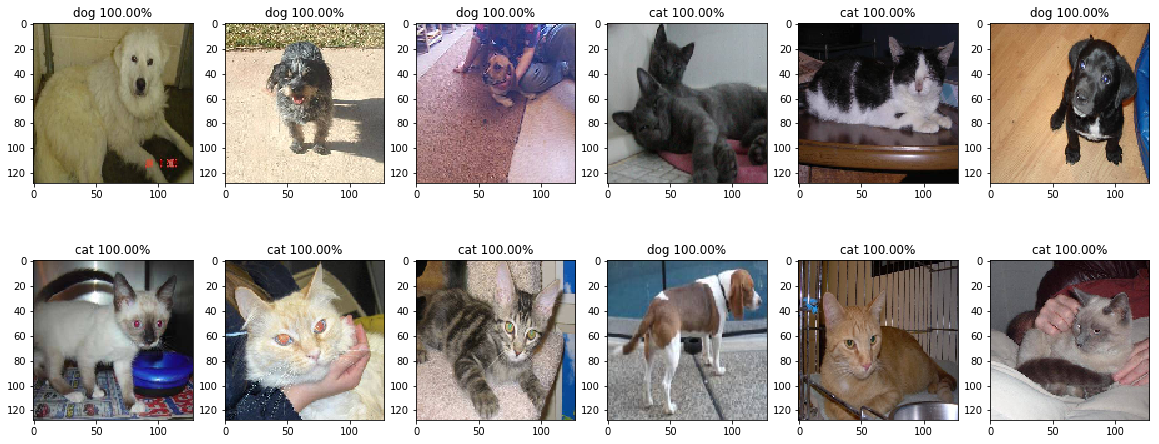

In [7]:
show_img_examples(x_train, y_train)

In [8]:
# searching params on 2000 samples
indices = np.arange(len(y_train))
np.random.shuffle(indices)
indices = indices[:200]
model = KerasClassifier(my_model, epochs=1, batch_size=64)
grid_params = {'lr':[0.0001, 0.001, 0.01]}
grid = GridSearchCV(model, grid_params, scoring='accuracy')
grid.fit(x_train[indices], y_train[indices])

Epoch 1/1
133/133 [==============================] - 22s 164ms/step - loss: 0.6993 - acc: 0.5038
Epoch 1/1
133/133 [==============================] - 24s 179ms/step - loss: 0.7271 - acc: 0.4361
Epoch 1/1
134/134 [==============================] - 29s 216ms/step - loss: 0.6636 - acc: 0.5746
Epoch 1/1
133/133 [==============================] - 27s 203ms/step - loss: 0.6418 - acc: 0.6391
Epoch 1/1
133/133 [==============================] - 179s 1s/step - loss: 0.7804 - acc: 0.5263
Epoch 1/1
134/134 [==============================] - 25s 185ms/step - loss: 0.5964 - acc: 0.6716
Epoch 1/1
133/133 [==============================] - 47s 353ms/step - loss: 0.8015 - acc: 0.6692
Epoch 1/1
133/133 [==============================] - 38s 288ms/step - loss: 0.9152 - acc: 0.6391
Epoch 1/1
134/134 [==============================] - 53s 395ms/step - loss: 0.5790 - acc: 0.67912s - loss: 0.5932 - acc: 0.6719
Epoch 1/1
200/200 [==============================] - 39s 194ms/step - loss: 0.6863 - acc: 0.6600


GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f840ac9a748>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr': [0.0001, 0.001, 0.01]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [9]:
# training on all training set
final_model = grid.best_estimator_.model
final_model.fit(x_train, y_train, validation_split=0.2, epochs=1, batch_size=64)
final_model.save('my_model.h5')

Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 390s 244ms/step - loss: 0.4229 - acc: 0.8225 - val_loss: 0.7360 - val_acc: 0.8325


In [11]:
ids, x_test = load_test_images('./test_spl')

preds = final_model.predict(x_test)

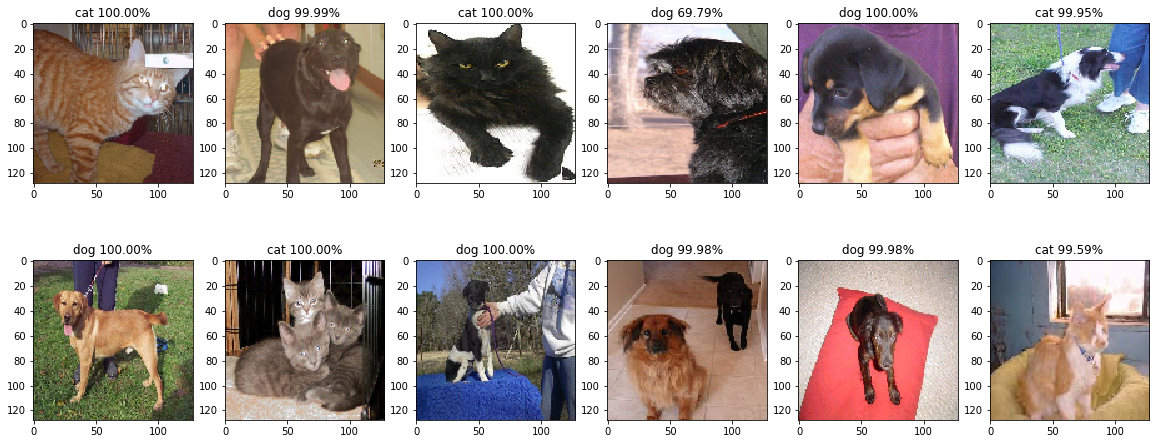

In [12]:
show_img_examples(x_test, preds[:,0])

In [15]:
# save predictions as a csv file
import pandas as pd
dic = {'id':ids, 'label':list(map(lambda x:'{:.4f}'.format(x), preds.flatten()))}
df = pd.DataFrame(dic)
df.to_csv('submission.csv', index=False)